In [45]:
import pandas as pd
import numpy as np
import re
import string
import contractions
import collections
from datetime import datetime
import time
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import tweepy
import matplotlib.pyplot as plt
import seaborn as sns
import config

In [2]:
from data_handler import HurricaneDataHandler as DH
from vectorize_text import TextVectors as TV
import captain_eda as eda

In [3]:
DATAH = DH()

27600
name 'Error' is not defined
Completed augmentation at 2022-12-09 20:52:21.628040. Consider rate limiting on API.


In [4]:
# training dataframe
df_training = DATAH.labeled_with_features
print(df_training.shape)
df_training.head(2)

(18663, 18)


,tweet_id,text,author_id,created_at,conversation_id,entities,context_annotations,edit_history_tweet_ids,in_reply_to_user_id,attachments,lang,possibly_sensitive,public_metrics,referenced_tweets,reply_settings,source,class_label,hurricane
0,910783670134476800,"""Hurricane Maria Live Updates: Catastrophic Fl...",627954585,2017-09-21 08:32:03+00:00,910783670134476800,"{'urls': [{'start': 99, 'end': 122, 'url': 'ht...","[{'domain': {'id': '13', 'name': 'Place', 'des...",[910783670134476800],no_value,no_value,en,no_value,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",no_value,everyone,no_value,caution_and_advice,Maria
1,912134938727780355,"Getting food to the island is, obviously, crit...",543450752,2017-09-25 02:01:30+00:00,912134938727780355,"{'urls': [{'start': 52, 'end': 75, 'url': 'htt...",no_value,[912134938727780355],no_value,no_value,en,no_value,"{'retweet_count': 3, 'reply_count': 0, 'like_c...","[(type, id)]",everyone,no_value,rescue_volunteering_or_donation_effort,Maria


In [5]:
# normalize the date ranges for each hurricane
df_normed = eda.normalize_dates(df_training)

In [6]:
# train the TFIDVectorizer, specify True for training
VECS = TV(df_training, True)

## Examine the training data

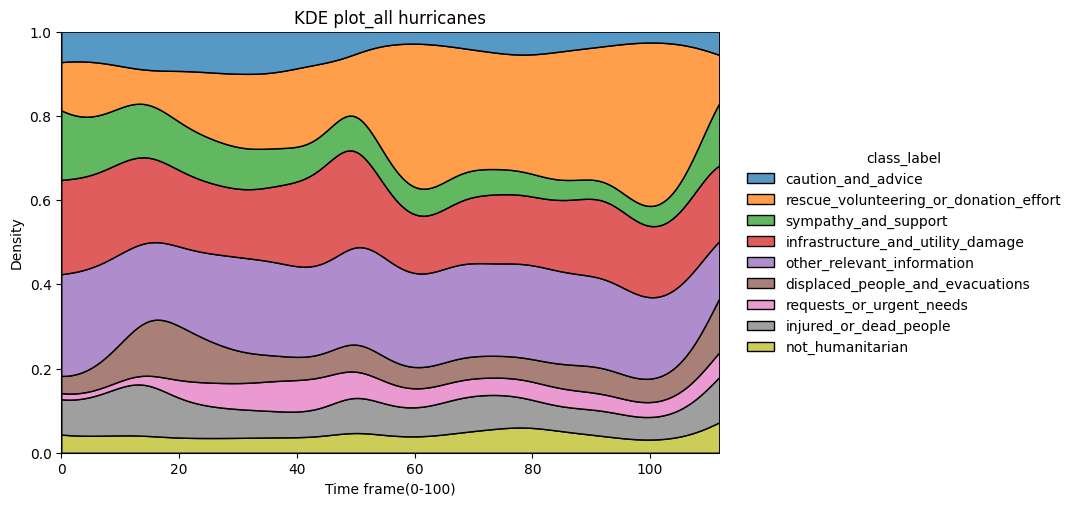

In [7]:
eda.all_kde(df_normed)
plt.show()

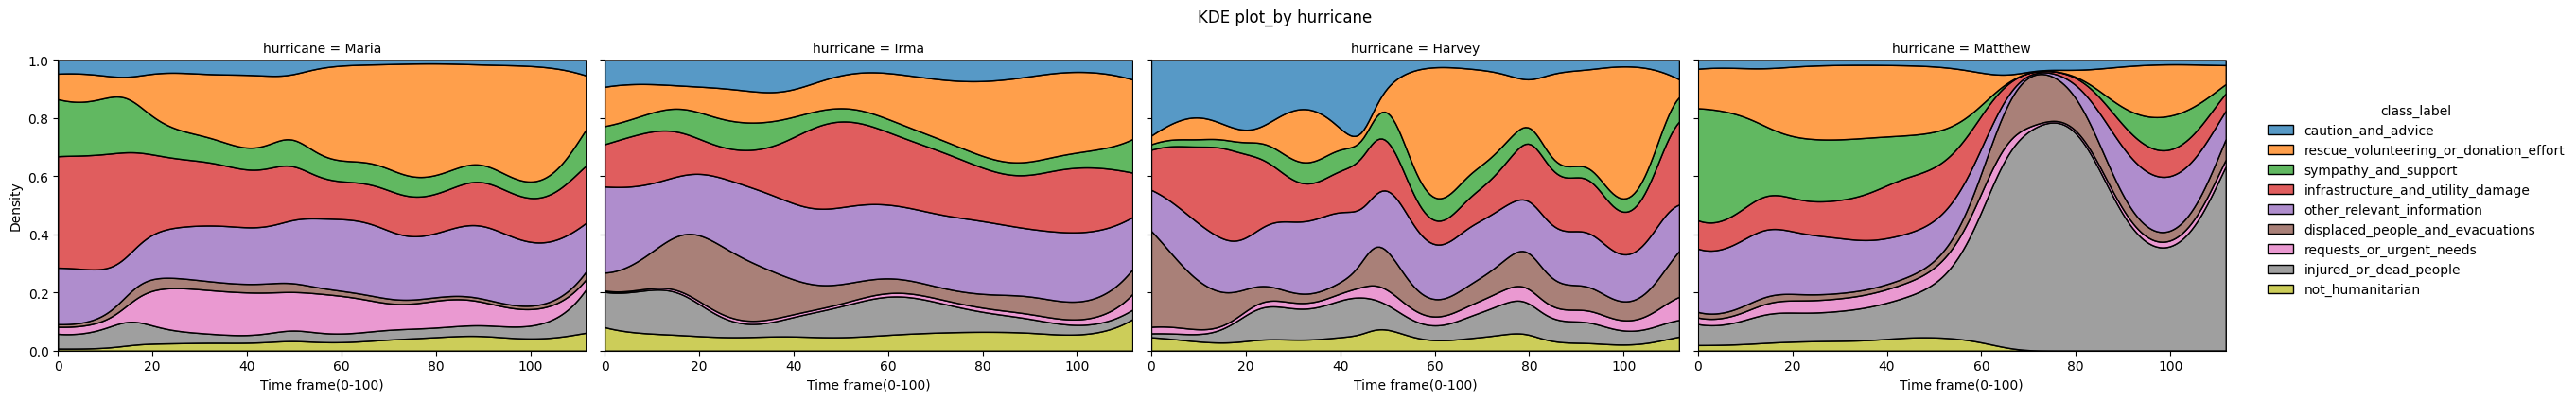

In [8]:
eda.comparison(df_normed)
plt.show()

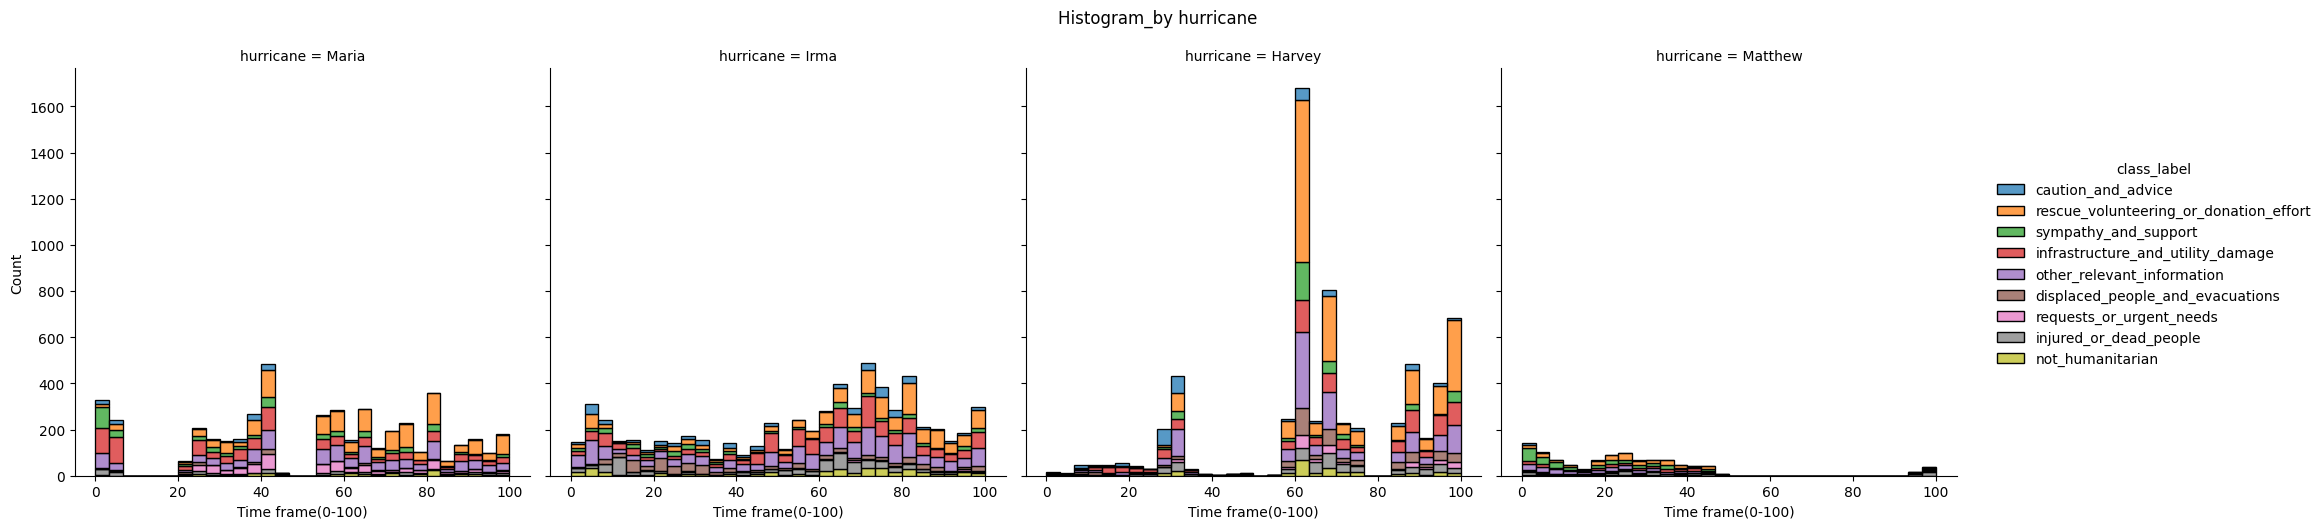

In [9]:
eda.displot_(df_normed)
plt.show()

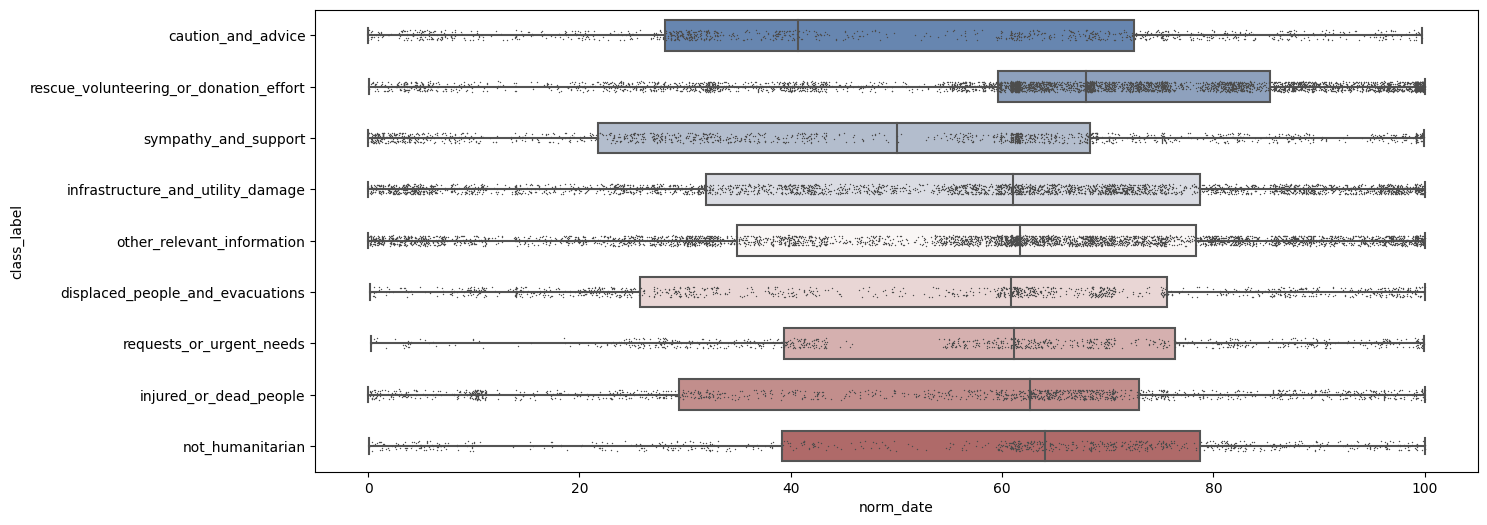

In [11]:
eda.strip_box(df_normed)
plt.show()

### Develop the model to determine if YES or NO it is a Hurricane related Tweet? 

In [12]:
# labeled set of data that establishes YES or NO hurricane related
df_mix = pd.read_csv('mix_yes_no_hurricane_2016_17.csv')
df_mix.head(2)

,created_at,edit_history_tweet_ids,author_id,source,in_reply_to_user_id,text,conversation_id,class_label,reply_settings,tweet_id,entities,attachments,lang,public_metrics,referenced_tweets,possibly_sensitive,is_hurricane
0,2016-10-04 20:53:38+00:00,[783409770493571076],30316960,TweetDeck,NaN,Horrifying. My heart breaks for Haiti. Thinkin...,7.834098e+17,sympathy_and_support,everyone,783409770493571076,"{'urls': [{'start': 110, 'end': 133, 'url': 'h...",NaN,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[<ReferencedTweet id=783408890222444548 type=q...,NaN,1
1,2016-10-08 10:07:32+00:00,[784696725285908481],2182497116,dlvr.it,NaN,#BreakingNews Hurricane Matthew kills over 800...,7.846967e+17,injured_or_dead_people,everyone,784696725285908481,"{'urls': [{'start': 78, 'end': 101, 'url': 'ht...",NaN,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,1


In [14]:
%%time
# create the X independent variables and y dependent variables for the model to observe
X = VECS(df_mix)
y = df_mix['is_hurricane']

CPU times: user 6.14 s, sys: 348 µs, total: 6.14 s
Wall time: 6.14 s


In [15]:
# use the parameters for the svc developed in prior testing
svc = SVC(C=10, gamma=1, kernel='rbf', random_state=42)

In [16]:
%%time
svc.fit(X, y)

CPU times: user 2min 10s, sys: 81.3 ms, total: 2min 10s
Wall time: 2min 10s


SVC(C=10, gamma=1, random_state=42)

### Develop the model to classify the hurricane related Tweets

In [17]:
# use the provided labeled data from the 2016 and 2017 storms
X = VECS.vector_X
y = df_training['class_label']

In [18]:
# use the Logistic Regression with the parameters identified from prior testing
lr = LogisticRegression(C=1.6, multi_class='multinomial')

In [19]:
%%time
lr.fit(X, y)

CPU times: user 56.8 s, sys: 2min 16s, total: 3min 12s
Wall time: 27.9 s


/home/cameron/Documents/MADS/699/DisasterTweets/MODELS/ENVIRONMENT/working_specs/team_hit/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.6, multi_class='multinomial')

# Demonstration

Given a collection of Tweet Ids and the name of the storm from the surrounding period of time, filter the list and examine those Tweets that are hurricane related for their underlying behavior. 

### Prepare the data

In [21]:
# open the file with the tweet ids and hurricane names
with open('ids_hurricane_name.txt', 'r') as file:
    lines = file.readlines()

In [27]:
# format the list of tuples to retrieve the full data
def find_ids_name(str):
    # split the string to find the id and hurricane name
    pattern = r"(\d+)\s([a-zA-Z]+)"
    str_obj = re.match(pattern, str)
    if str_obj is not None:
        return (str_obj[1], str_obj[2])
    else:
        return "no_match"

In [30]:
id_name_tuples = [find_ids_name(x) for x in lines]
len(id_name_tuples)

79060

In [32]:
# filter bad entries by 'no_match'
ids_names = [x for x in id_name_tuples if x != "no_match"]
len(ids_names)

79055

In [ ]:
# select a third of these values to manage rate limiting
ids_names = random.sample(ids_names, 20000)

In [37]:
# recover the full information on the Tweet from the Twitter API using the DataHandler
target_ids = [x[0] for x in ids_names]
storm_names = [x[1] for x in ids_names]
len(target_ids), len(storm_names)

(79055, 79055)

### Download the Tweets using the DataHandler and target_ids

In [39]:
%%time
df_unk = DATAH(target_ids, 0)
df_unk.shape

Rate limit exceeded. Sleeping for 376 seconds.


30100
name 'Error' is not defined
CPU times: user 33.2 s, sys: 162 ms, total: 33.3 s
Wall time: 20min 39s


In [40]:
df_unk.head(2)

,tweet_id,text,author_id,created_at,conversation_id,entities,context_annotations,edit_history_tweet_ids,in_reply_to_user_id,attachments,lang,possibly_sensitive,public_metrics,referenced_tweets,reply_settings,source
0,1279339158079541248,RT @jonfavs: I never thought Trump sticking to...,239025975,2020-07-04 08:59:58+00:00,1279339158079541248,"{'mentions': [{'start': 3, 'end': 11, 'usernam...","[{'domain': {'id': '10', 'name': 'Person', 'de...",[1279339158079541248],no_value,no_value,en,no_value,"{'retweet_count': 3675, 'reply_count': 0, 'lik...","[(type, id)]",everyone,Twitter for Android
0,1279339151859478528,@Isaias91061781 Isaias wtf,782680651963043840,2020-07-04 08:59:57+00:00,1279338294321442816,"{'mentions': [{'start': 0, 'end': 15, 'usernam...",no_value,[1279339151859478528],1258801263170355200,no_value,et,no_value,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","[(type, id)]",everyone,Twitter for iPhone


### Filter the Tweets that are not hurricane related

In [47]:
%%time
# vectorize the text using the vectorizer train for the models; False for not training a new vectorizer 
unk_vecs = VECS(df_unk)

CPU times: user 7.61 s, sys: 1.55 ms, total: 7.61 s
Wall time: 7.61 s


In [48]:
%%time
# predict YES/NO hurricane related
pred_yes_no = svc.predict(unk_vecs)

CPU times: user 27.5 s, sys: 0 ns, total: 27.5 s
Wall time: 27.6 s


In [62]:
# filter the new data
df_unk['is_hurricane'] = pred_yes_no
df_tgt = df_unk[df_unk['is_hurricane'] == 1]
df_tgt.shape

(15952, 17)

### Predict the classes of the Tweets

In [63]:
%%time
tgt_vecs = VECS(df_tgt)

CPU times: user 3.88 s, sys: 0 ns, total: 3.88 s
Wall time: 3.88 s


In [64]:
predict_classes = lr.predict(tgt_vecs)

In [65]:
df_tgt['class_label'] = predict_classes

/tmp/ipykernel_8356/3989052324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tgt['class_label'] = predict_classes


In [69]:
print(df_tgt.shape)
df_tgt.head(3)

(15952, 19)


,tweet_id,text,author_id,created_at,conversation_id,entities,context_annotations,edit_history_tweet_ids,in_reply_to_user_id,attachments,lang,possibly_sensitive,public_metrics,referenced_tweets,reply_settings,source,is_hurricane,class_label,date
0,1279339158079541248,RT @jonfavs: I never thought Trump sticking to...,239025975,2020-07-04 08:59:58+00:00,1279339158079541248,"{'mentions': [{'start': 3, 'end': 11, 'usernam...","[{'domain': {'id': '10', 'name': 'Person', 'de...",[1279339158079541248],no_value,no_value,en,no_value,"{'retweet_count': 3675, 'reply_count': 0, 'lik...","[(type, id)]",everyone,Twitter for Android,1,other_relevant_information,2020-07-04 08:59:58+00:00
0,1279339151859478528,@Isaias91061781 Isaias wtf,782680651963043840,2020-07-04 08:59:57+00:00,1279338294321442816,"{'mentions': [{'start': 0, 'end': 15, 'usernam...",no_value,[1279339151859478528],1258801263170355200,no_value,et,no_value,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","[(type, id)]",everyone,Twitter for iPhone,1,other_relevant_information,2020-07-04 08:59:57+00:00
0,1279339077033222154,RT @Jamie_Woodward_: “The cave passages exhibi...,1169964828619943937,2020-07-04 08:59:39+00:00,1279339077033222154,"{'mentions': [{'start': 3, 'end': 19, 'usernam...",no_value,[1279339077033222154],no_value,no_value,en,no_value,"{'retweet_count': 3, 'reply_count': 0, 'like_c...","[(type, id)]",everyone,Twitter for Android,1,other_relevant_information,2020-07-04 08:59:39+00:00


## Display the results of the class predictions

### Combine the hurricane names and Normalize the dates

In [75]:
# form a dataframe for ids and storm name
df_ids_names = pd.DataFrame({'tweet_id': target_ids, 'hurricane': storm_names})
df_ids_names['tweet_id'] = df_ids_names['tweet_id'].astype('int64')
df_ids_names.shape

(79055, 2)

In [77]:
df_comb = df_tgt.merge(df_ids_names, on='tweet_id', how='inner')
df_comb.shape

(15952, 20)

In [84]:
# normalize the date ranges for each hurricane
df_normed_tgt_othr = eda.normalize_dates(df_comb)

In [86]:
# filter the class imbalance
df_normed_tgt = df_normed_tgt_othr[df_normed_tgt_othr['class_label'] != 'other_relevant_information']
df_normed_tgt.shape

(4601, 21)

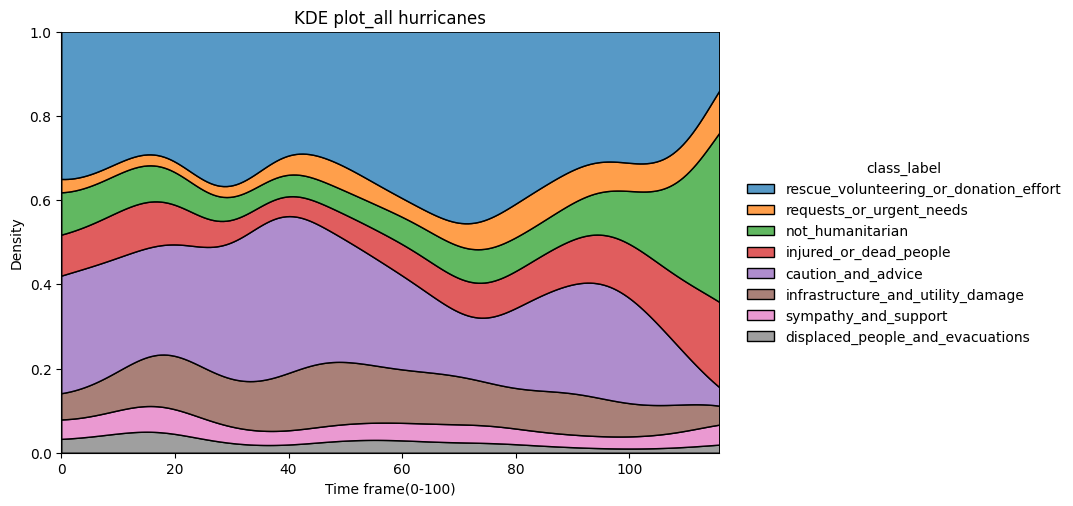

In [87]:
eda.all_kde(df_normed_tgt)
plt.show()

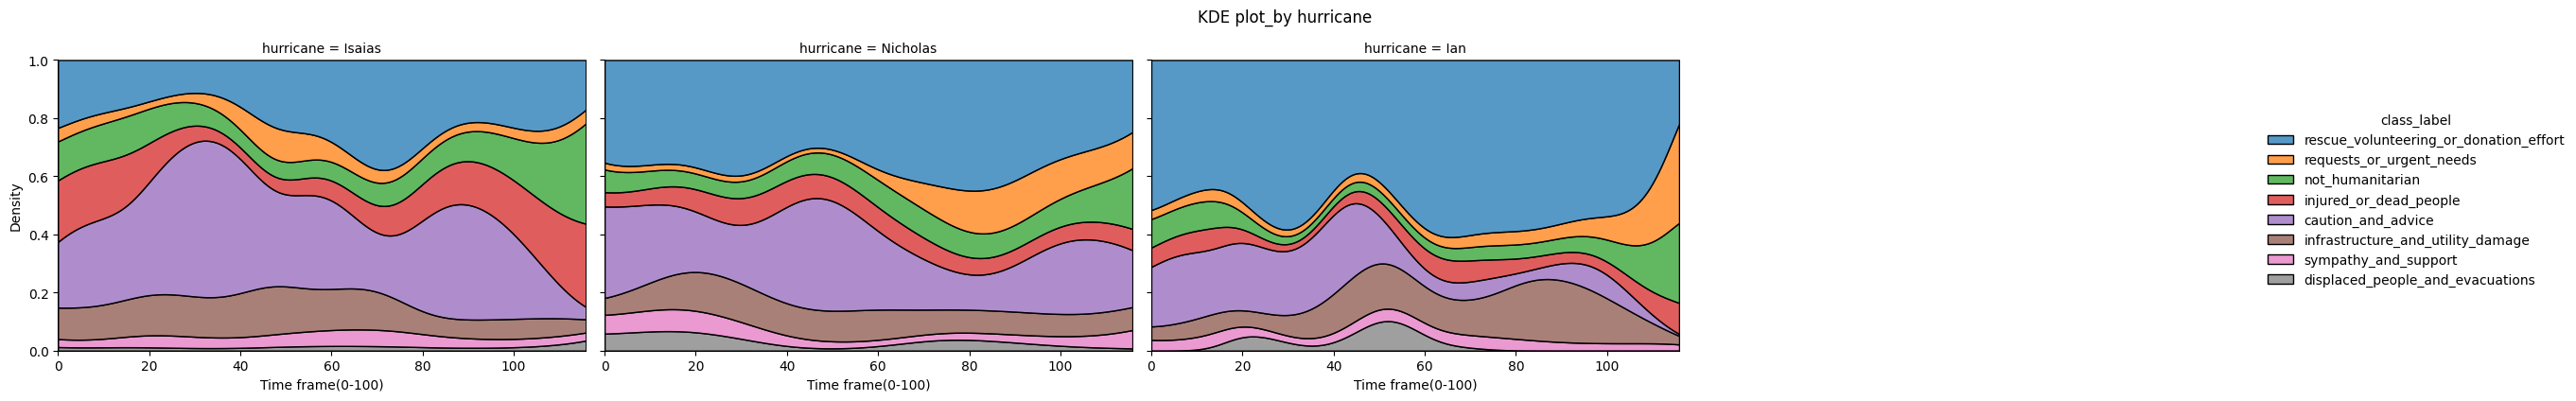

In [88]:
eda.comparison(df_normed_tgt)
plt.show()

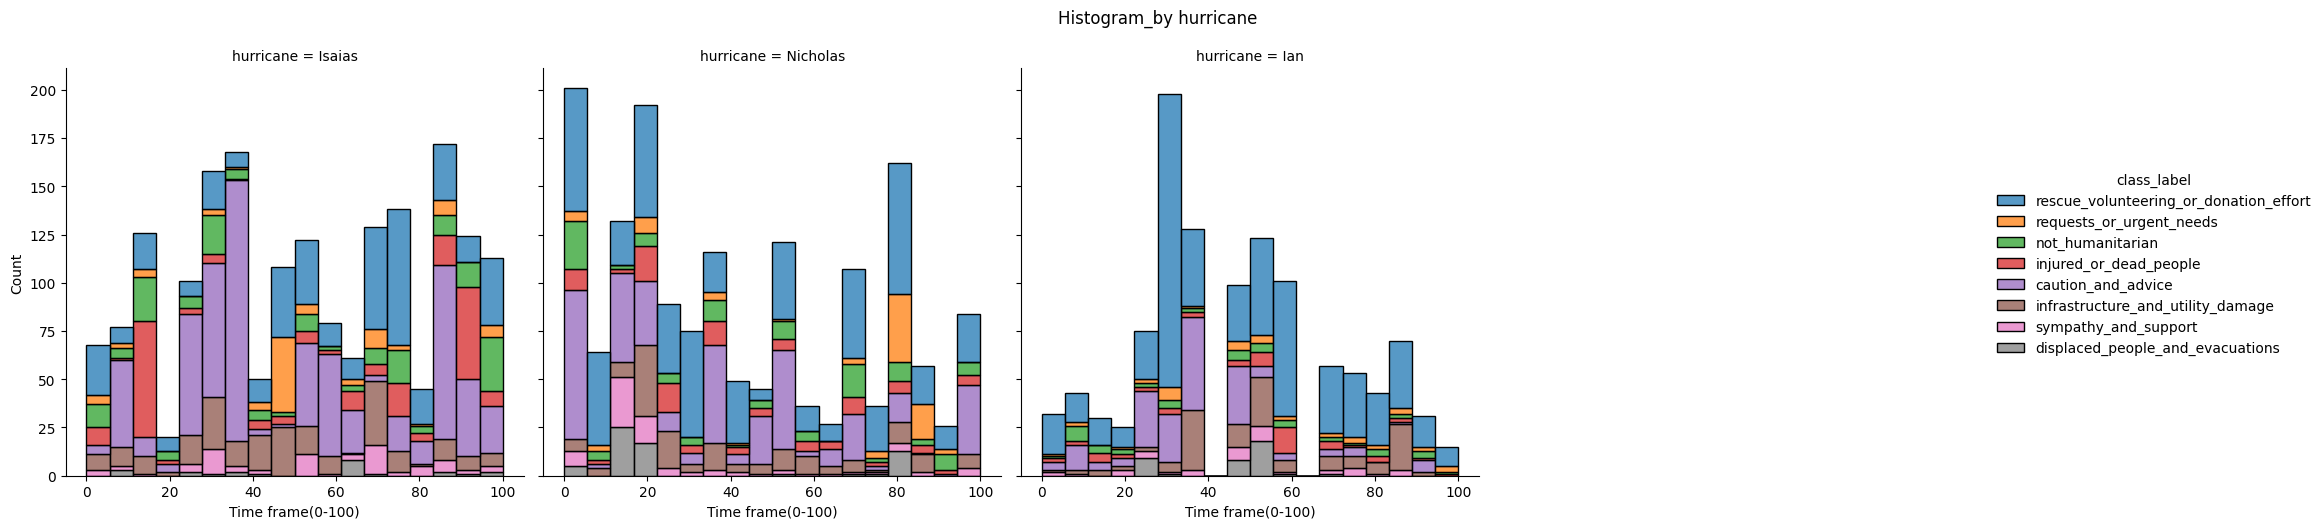

In [89]:
eda.displot_(df_normed_tgt)
plt.show()

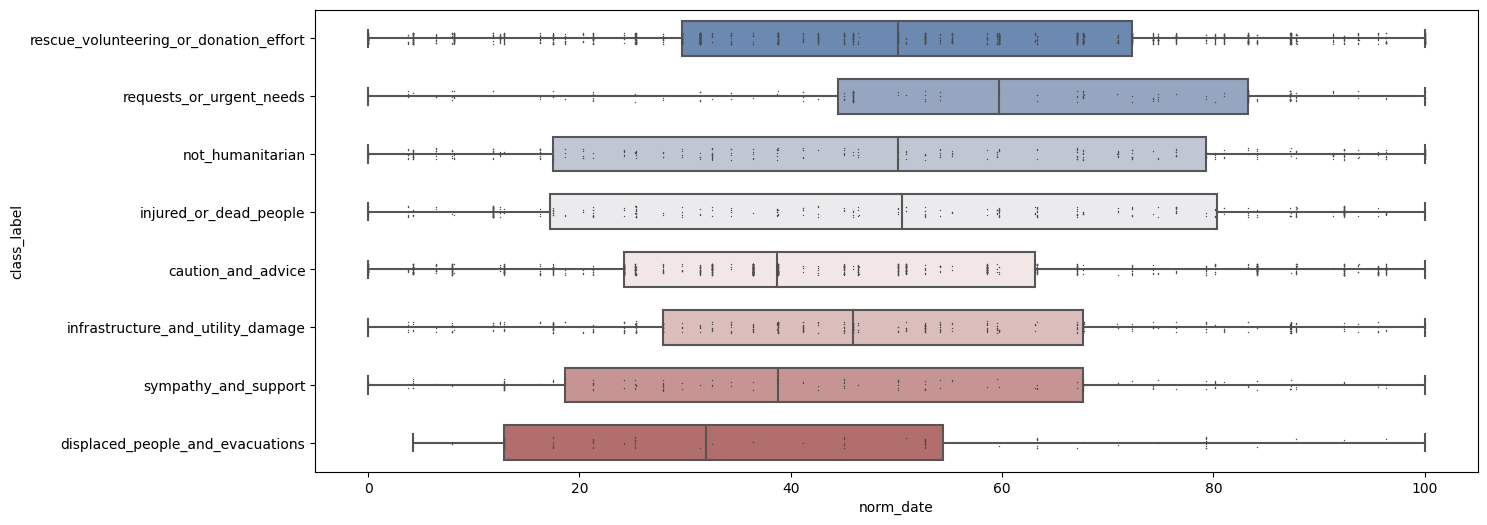

In [90]:
eda.strip_box(df_normed_tgt)
plt.show()